In [1]:

import numpy as np
from scipy.stats import multivariate_normal
import itertools

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import os

import sys

module_path = os.path.abspath(os.path.join('/home/adaboost/Documents/github/pyStateEstimator'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from MomentMatching.baseMomentMatch import MomentMatching, UnscentedTransform
from MomentMatching.TimeSeriesModel import TimeSeriesModel, UniformNonlinearGrowthModel
from MomentMatching.StateModels import GaussianState

In [5]:
class KalmanFilterSmoother:
    def __init__(self, moment_matching, system_model):
        """
        moment matching implements the transfer function needed.

        """
        assert isinstance(system_model, TimeSeriesModel)  # make sure we are working with the time series model.
        assert isinstance(moment_matching, MomentMatching)

        self.transition = system_model.transition_function
        self.measurement = system_model.measurement_function
        self.init_dist = system_model.init_dist
        self.moment_matching = moment_matching
        self.predict = moment_matching.predict
        self.system_model = system_model

    #         self.init_dist = system_model.init_dist

    def kalman_filter(self,  prior_distribution, t,  observations):

        if prior_distribution is None:
            x_distribution = self.init_distribution
        else:
            x_distribution = prior_distribution

        for observation in observations:
            x_filtered_distribution = self._filter(x_distribution, t, observation)
            yield x_filtered_distribution
            x_distribution = x_filtered_distribution
            t += 1
            
    def kalman_smoother(self, reversible_container, t, already_reversed=False):
        if already_reversed:
            reversed_iterator = reversible_contaianer
        else:
            reversed_iterator = reversed(reversible_container)
            
#         x_distribution, x_next_distribution = self._pairwise(reversed_iterator)
        
        for x_next_distribution, x_distribution in self._pairwise(reversed_iterator):
            x_smoothed_dist = self._smoother(x_distribution, x_next_distribution, t)
            t-= 1
            yield x_smoothed_dist
        
    
    
    def _pairwise(self, state_distribution_iterable):
        """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
        x_distribution, x_next_distribution = itertools.tee(state_distribution_iterable)
        next(x_distribution, None)
        return zip(x_distribution, x_next_distribution)

    def _filter(self, x_distribution, t, z_measurement):
        pred_mean, pred_cov, _ = self.predict(self.transition, x_distribution, t)
#         print(t)
        # Add transition Noise Q_t
        pred_cov = pred_cov + self.system_model.Q.cov
        pred_distribution = GaussianState(pred_mean, pred_cov)

        z_mean, z_cov, xz_cross_cov = self.predict(self.measurement, pred_distribution)
        # Add measurement Noise R_t
        z_cov = z_cov + self.system_model.R.cov

        K = np.matmul(xz_cross_cov, np.linalg.inv(z_cov))
        corrected_mean = pred_mean + np.dot(K, (z_measurement - z_mean))  # equation 15  in Marc's ACC paper
        corrected_cov = pred_cov - np.dot(K, np.transpose(xz_cross_cov))
        filtered_distribution = GaussianState(corrected_mean, corrected_cov)
        return filtered_distribution

    def _smoother(self, x_distribution, x_next_distribution, t):
        xx_mean, xx_cov, xx_cross_cov, = self.predict(self.transition, x_distribution, t)
        # Add transition Noise Q_t
        xx_cov = xx_cov + self.system_model.Q.cov

        # calculate smoother gain J_t
        J = np.dot(xx_cross_cov, np.linalg.inv(xx_cov))

        smoothed_mean = x_distribution.mean + np.dot(J, (x_next_distribution.mean - xx_mean))
        smoothed_cov = x_distribution.cov + np.dot(np.dot(J, x_next_distribution.cov - xx_cov), J.T)
        smoothed_distribution = GaussianState(smoothed_mean, smoothed_cov)
        return smoothed_distribution

    def _step_kalman_filter(self, x_distribution, z_observation):
        """
        This is a single step in kalman filter

        1) Given x_mean and x_sigma predict the t+1 value using transistion
            function and moment matching method

        2) Project latent state through  measurement function to obtain predcitive
           observation density

        3) correct the density using Kalman gain


        We use x as latent state distribution
        """

        x_t_plus_1 = self.moment_matching.predict(self.system_model.transition_function, x_distribution)

        pred_mean, pred_cov = self.predict(self.transition, x_distribution)
        pred_distribution = GaussianState(pred_mean, pred_cov)

        z_mean, xz_sigma, z_sigma = self.predict(self.measurement, pred_distribution)

        # calculate Kalman Gain K
        K = np.matmul(xz_sigma, np.linalg.inv(z_sigma))
        corrected_mean = x_mean + np.dot(K, (z_observation - z_mean))  # equation 15  in Marc's ACC paper
        corrected_cov = x_sigma - np.dot(K, np.transpose(xz_sigma))
        x_distribution_new = GaussianState(corrected_mean, corrected_cov)
        yield x_distribution_new

    def _predict(self, x_mean, xx_sigma):
        # we don't need cross covariance here, ignore it
        pred_mean, _, pred_sigma = self.transition_model.predict_transition(x_mean, xx_sigma)

        return pred_mean, pred_sigma

    def correct(self, z_observation, x_mean, x_sigma):
        # Todo : Check if it is better to pass inverse always or to use Cholesky for stability
        # (Numpy lstq or solve may work)
        z_mean, xz_sigma, z_sigma = self.observation_model.predict_observation(x_mean, x_sigma)

        # calculate Kalman Gain K
        K = np.matmul(xz_sigma, np.linalg.inv(z_sigma))
        corrected_mean = x_mean + np.dot(K, (z_observation - z_mean))  # equation 15  in Marc's ACC paper
        corrected_sigma = x_sigma - np.dot(K, np.transpose(xz_sigma))
        return corrected_mean, corrected_sigma

    def smooth(self, x_mean, x_sigma, x_next_mean, x_next_sigma):
        xx_mean, xx_cross_sigma, xx_sigma = self.transition_model.predict_transition(x_mean, x_sigma)

        # calculate smoother gain J_t
        J = np.dot(xx_cross_sigma, np.linalg.inv(xx_sigma))

        smoothed_mean = x_mean + np.dot(J, (x_next_mean - xx_mean))
        smoothed_sigma = x_sigma + np.dot(np.dot(J, x_next_sigma - xx_sigma), np.transpose(J))
        return smoothed_mean, smoothed_sigma

In [6]:
# reversed_data_dist = reversed (data_dist)

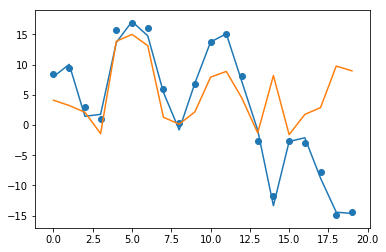

In [7]:
N = 20
demo = UniformNonlinearGrowthModel()
data = demo.system_simulation(N)
x_true, x_noisy, y_true, y_noisy = zip(*data)

plt.plot(x_true)

plt.scatter(list(range(N)), x_noisy)
plt.plot(y_noisy)

In [8]:
kf = KalmanFilterSmoother(moment_matching=UnscentedTransform(), system_model=demo)
data_dist = kf.kalman_filter(demo.init_dist, 0, y_noisy)
filtered_data = list(itertools.islice(data_dist, N))
data_filter_gen = kf.kalman_smoother(filtered_data, N-2)
smthd_data = list(itertools.islice(data_filter_gen, N))

In [9]:
%timeit filtered_data = list(itertools.islice(kf.kalman_filter(demo.init_dist, 0, y_noisy), N))

100 loops, best of 3: 3.49 ms per loop


In [10]:
# x_filtered, x_err = (filtered.mean[0, :], np.sqrt(filtered_data.cov[0, 0]) for filtered in filtered_data)
# x_smthd = [smthd.mean[0, :] for smthd in smthd_data]

In [11]:
def get_mean_err(x):
    return x.mean, 2* np.sqrt(x.cov[0, 0])

In [12]:
# x_filtered[0].shape

In [13]:
# x_distribution = demo.init_dist
# 

In [14]:
# x_true[0].shape

In [15]:
x_filtered, x_filtered_err = zip(*[get_mean_err(x) for x in filtered_data])
x_smthd, x_smthd_err = zip(*[get_mean_err(x) for x in smthd_data])

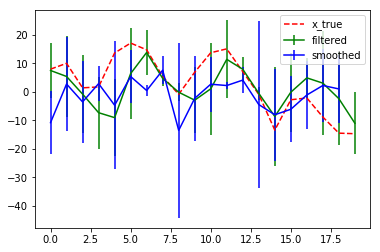

In [16]:
plt.plot(x_true, 'r--', label='x_true')

# plt.scatter(list(range(50)), x_noisy)
# plt.plot(y_noisy)
plt.errorbar(list(range(N)), y=x_filtered, yerr=x_filtered_err, color='g', label='filtered')
plt.errorbar(list(range(N-1)), y=x_smthd, yerr=x_smthd_err, color='b', label='smoothed')
plt.legend()

In [17]:
demo.Q.cov

array([[ 1.]])

In [18]:
def _filter(self, x_distribution, t, z_measurement):
    pred_mean, pred_cov, _ = self.predict(self.transition, x_distribution , t)
    
    # Add transition Noise Q_t
    pred_cov = pred_cov + self.system_model.Q.cov
    pred_distribution = GaussianState(pred_mean, pred_cov)
    
    z_mean, z_cov, xz_cross_cov = self.predict(self.measurement, pred_distribution)
    # Add measurement Noise R_t
    z_cov = z_cov + self.system_model.R.cov

    K = np.matmul(xz_cross_cov, np.linalg.inv(z_cov))
    corrected_mean = pred_mean + np.dot(K, (z_measurement - z_mean))  # equation 15  in Marc's ACC paper
    corrected_cov = pred_cov - np.dot(K, np.transpose(xz_cross_cov))
    filtered_distribution = GaussianState(corrected_mean, corrected_cov)
    return filtered_distribution
    

In [19]:
def _smoother(self, x_distribution, x_next_distribution, t):
    xx_mean,  xx_cov, xx_cross_cov, = self.predict(self.transition, x_distribution , t)
    # Add transition Noise Q_t
    xx_cov = xx_cov + self.system_model.Q.cov
    
    # calculate smoother gain J_t
    J = np.dot(xx_cross_cov, np.linalg.inv(xx_cov))

    smoothed_mean = x_distribution.mean + np.dot(J, (x_next_distribution.mean - xx_mean))
    smoothed_cov = x_distribution.cov + np.dot(np.dot(J, x_next_distribution.cov - xx_cov), J.T)
    smoothed_distribution = GaussianState(smoothed_mean, smoothed_cov)
    return smoothed_distribution

In [20]:
pred_new1 = _filter(kf, demo.init_dist, 0, z_measurement=y_noisy[0])
pred_new2 = _filter(kf, pred_new1, 1, z_measurement=y_noisy[1])

In [21]:
daba = list(range(20))
daba = reversed(daba)
print(len(list(kf._pairwise(daba))))

19


In [22]:
pred_new2.nll(x_true[1])

3.0887544677830538

In [23]:
smthd = _smoother(kf, pred_new1, pred_new2, 1)

In [24]:
smthd.nll(x_true[0])

2.4401224571032136

In [25]:
smthd.rmse(x_true[0])

1.1023788054018215

In [26]:
pred_new1.rmse(x_true[0])

0.47690804774534268

In [27]:
x_true[0]

array([ 8.])

In [28]:
smthd.mean

array([ 6.89762119])

In [29]:
pred_new1.cov

array([[ 23.98893692]])

In [30]:
pred_new1.mean 

array([ 7.52309195])

In [31]:
smthd.cov

array([[ 19.70130072]])

In [32]:
pred_mean, pred_cov, _ = kf.predict(kf.transition, pred_new1 , 1)
pred_cov = pred_cov + kf.system_model.Q.cov
pred_distribution = GaussianState(pred_mean, pred_cov)  
z_mean, z_cov, xz_sigma, = kf.predict(kf.measurement, pred_distribution)
z_cov = z_cov + kf.system_model.R.cov
K = np.matmul(xz_sigma, np.linalg.inv(z_cov))

In [33]:
xz_sigma

array([[ 54.77309727]])

In [34]:
# np.linalg.inv(z_sigma)

In [35]:
nodes = list(range(20))

In [36]:
nodes_gen = range(24)

In [37]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b, c = tee(iterable, 3)
    next(b, None)
    next(c, None)
    next(c, None)
    return zip(a, b, c)

In [38]:
list(pairwise(nodes_gen))

[(0, 1, 2),
 (1, 2, 3),
 (2, 3, 4),
 (3, 4, 5),
 (4, 5, 6),
 (5, 6, 7),
 (6, 7, 8),
 (7, 8, 9),
 (8, 9, 10),
 (9, 10, 11),
 (10, 11, 12),
 (11, 12, 13),
 (12, 13, 14),
 (13, 14, 15),
 (14, 15, 16),
 (15, 16, 17),
 (16, 17, 18),
 (17, 18, 19),
 (18, 19, 20),
 (19, 20, 21),
 (20, 21, 22),
 (21, 22, 23)]

In [39]:
# corrected_mean = pred_mean + np.dot(K, (z_measurement - z_mean))

In [40]:
# corrected_mean

In [41]:
# z_sigma

In [42]:
y_noisy[1]

array([ 3.22834938])

In [43]:
x_true[1]

array([ 10.04410293])

In [44]:
pred_new1.cov

array([[ 23.98893692]])

In [45]:
pred_new1.nll(x_true[0])

2.5124754597065193

In [46]:
pred_new2.cov

array([[ 50.17313337]])

In [47]:
pred_new2.nll(x_true[1])

3.0887544677830538

In [48]:
pred_mean

array([ 7.02385551])

In [49]:
pred_cov

array([[ 77.98152625]])

In [50]:
x_noisy[0]

array([ 8.46531267])

In [51]:
z_measurement - z_mean

NameError: name 'z_measurement' is not defined

In [ ]:
y_true[0]

In [ ]:
corrected_mean

In [ ]:
corrected_sigma

In [ ]:
_filter()

In [ ]:
corrected_rv = 

In [ ]:
rv_corrected = multivariate_normal(mean=corrected_mean, cov=corrected_sigma)
rv_predicted = multivariate_normal(mean=pred_mean, cov=pred_cov)

In [ ]:
rv_corrected.logpdf(x_true[0])



In [ ]:
rv_predicted.logpdf(x_true[0])

In [ ]:
np.testing.assert_allclose(X[:,0:1], np.sin(Xnew))

In [ ]:
for i in range(Xnew.shape[1]):
    if i in self.params['n_theta']:
        X[:, j] = np.sin(Xnew[:, i])
        j += 1
        X[:, j] = np.cos(Xnew[:, i])
    else:
        X[:, j] = Xnew[:, i]
        j += 1

In [ ]:
Xvar = np.tile(np.eye(3), (9, 1) )

In [ ]:
Xvar = Xvar.reshape(9,3,3)

In [ ]:
Xvar.shape

In [ ]:
class KalmanFilterSmootherOLD:
    def __init__(self, moment_matching, system_model):
        """
        moment matching implements the transfer function needed.

        """
        assert isinstance(system_model, TimeSeriesModel)  # make sure we are working with the time series model.
        assert isinstance(moment_matching, MomentMatching)

        self.transition = system_model.transition_function
        self.measurement = system_model.measurement_function
        self.init_dist = system_model.init_dist
        self.moment_matching = moment_matching
        self.predict = moment_matching.predict
        self.system_model = system_model

    #         self.init_dist = system_model.init_dist

    def kalman_filter(self, noisy_observations, *args, prior_distribution=None):

        if prior_distribution is None:
            x_distribution = self.init_distribution
        else:
            x_distribution = prior_distribution

        for observation in noisy_observations:
            x_filtered_distribution = self._step_kalman_filter(x_distribution, observation)
            yield x_filtered_distribution
            x_distribution = x_filtered_distribution

    def _step_kalman_filter(self, x_distribution, z_observation):
        """
        This is a single step in kalman filter

        1) Given x_mean and x_sigma predict the t+1 value using transistion
            function and moment matching method

        2) Project latent state through  measurement function to obtain predcitive
           observation density

        3) correct the density using Kalman gain


        We use x as latent state distribution
        """

#         x_t_plus_1 = self.moment_matching.predict(self.system_model.transition_function, x_distribution)

        pred_mean, pred_cov = self.predict(self.transition, x_distribution)
        pred_distribution = GaussianState(pred_mean, pred_cov)

        z_mean, xz_sigma, z_sigma = self.predict(self.measurement, pred_distribution)

        # calculate Kalman Gain K
        K = np.matmul(xz_sigma, np.linalg.inv(z_sigma))
        corrected_mean = x_mean + np.dot(K, (z_observation - z_mean))  # equation 15  in Marc's ACC paper
        corrected_cov = x_sigma - np.dot(K, np.transpose(xz_sigma))
        x_distribution_new = GaussianState(corrected_mean, corrected_cov)
        return x_distribution_new

    def _predict(self, x_mean, xx_sigma):
        # we don't need cross covariance here, ignore it
        pred_mean, _, pred_sigma = self.transition_model.predict_transition(x_mean, xx_sigma)

        return pred_mean, pred_sigma

    def correct(self, z_observation, x_mean, x_sigma):
        # Todo : Check if it is better to pass inverse always or to use Cholesky for stability
        # (Numpy lstq or solve may work)
        z_mean, xz_sigma, z_sigma = self.observation_model.predict_observation(x_mean, x_sigma)

        # calculate Kalman Gain K
        K = np.matmul(xz_sigma, np.linalg.inv(z_sigma))
        corrected_mean = x_mean + np.dot(K, (z_observation - z_mean))  # equation 15  in Marc's ACC paper
        corrected_sigma = x_sigma - np.dot(K, np.transpose(xz_sigma))
        return corrected_mean, corrected_sigma

    def smooth(self, x_mean, x_sigma, x_next_mean, x_next_sigma):
        xx_mean, xx_cross_sigma, xx_sigma = self.transition_model.predict_transition(x_mean, x_sigma)

        # calculate smoother gain J_t
        J = np.dot(xx_cross_sigma, np.linalg.inv(xx_sigma))

        smoothed_mean = x_mean + np.dot(J, (x_next_mean - xx_mean))
        smoothed_sigma = x_sigma + np.dot(np.dot(J, x_next_sigma - xx_sigma), np.transpose(J))
        return smoothed_mean, smoothed_sigma

In [ ]:
from numpy import random
np.unique([( random.randint(0, 10)) for k in range(3)])